# CH 5 추천 알고리즘 상세
- 구체적인 추천 시스템 알고리즘 소개
- MovieLens 영화 데이터셋을 샘플 데이터로 사용
- 실무에서 직면하는 문제점이나 대처법도 같이 찾아보자
- [파이썬 샘플 코드는 여기를 클릭!](https://github.com/moseskim/RecommenderSystems)

## 5.1 알고리즘 비교
- 10종류 이상의 알고리즘 소개. 순서대로 읽을 필요 없이 흥미가 있는 것부터 읽어봐도 좋음
- 간단한 추천 모델은 인기도 추천이나 연관규칙, 정확도를 높이고 싶다면 LDA나 word2vec, 머신러닝 방법 등이 있음
- 협조 필터링에서 정확도를 높이고 싶다면 행렬 분해 계열, 머신러닝 방법을 추천
- 하이브리드로 정확도를 높이고 싶다면 회귀 모델이나 FM, 머신러닝 방법을 추천
- 추천 알고리즘 비교
  
  ![추천 알고리즘 비교1](./images/tbl_5-1-1.png)

  ![추천 알고리즘 비교2](./images/tbl_5-1-2.png)

## 5.2 MovieLens 데이터셋
- 미네소타 대학의 그룹렌즈 연구소가 구축한 영화 평가 데이터셋
- MovieLens 데이터셋에는 몇 가지 종류가 있으며 여기서는 MovieLens 10M Dataset이라는 데이터셋 사용
- 1,000만 건의 영화 평가값이 있으며 각 영화에 자유 형식의 텍ㄱ스트로 부여한 '지브리', '어린이용', '무서워' 등의 태그 정보도 포함

### 5.2.1 데이터 다운로드
- https://grouplens.org/datasets/movielens/10m/ 에서 ml-10m.zip 파일을 다운로드

In [6]:
# MovieLens 데이터셋을 data 디렉터리에 다운로드한 뒤, 압축을 푼다
!wget -nc --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-10m.zip -P ./data
!unzip -n ml-10m.zip -d ./data

--2024-02-17 13:56:17--  https://files.grouplens.org/datasets/movielens/ml-10m.zip
files.grouplens.org (files.grouplens.org) 해석 중... 128.101.65.152
다음으로 연결 중: files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 65566137 (63M) [application/zip]
저장 위치: `./data/ml-10m.zip'

ml-10m.zip          100%[===================>]  62.53M  6.91MB/s    /  11s     

2024-02-17 13:56:29 (5.73 MB/s) - `./data/ml-10m.zip' 저장함 [65566137/65566137]

Archive:  ml-10m.zip
   creating: ./data/ml-10M100K/
  inflating: ./data/ml-10M100K/allbut.pl  
  inflating: ./data/ml-10M100K/movies.dat  
  inflating: ./data/ml-10M100K/ratings.dat  
  inflating: ./data/ml-10M100K/README.html  
  inflating: ./data/ml-10M100K/split_ratings.sh  
  inflating: ./data/ml-10M100K/tags.dat  


- 폴더 안에 있는 데이터 중 주로 아래의 파일을 사용
  ![MovieLens 데이터셋 내용](./images/tbl_5-2.png)

### 5.2.2 MovieLens 데이터 개요
- 이제 아래의 데이터의 특성을 확인
  - 데이터의 특징을 탐색적으로 조사하는 것을 탐색적 데이터 분석(EDA)라고 부름

In [4]:
import pandas as pd

In [18]:
# 영화정보 로딩(10681작품)
# movieID와 제목만 사용
m_cols = ['movie_id', 'title', 'genre']
movies = pd.read_csv('./data/ml-10M100K/movies.dat', names=m_cols, sep='::' , encoding='latin-1', engine='python')

# genre를 list 형식으로 저장한다, 참고 : 장르는 20종류
movies['genre'] = movies.genre.apply(lambda x:x.split('|'))
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [19]:
# 사용자 부여한 영화의 태그 정보 로딩
t_cols = ['user_id', 'movie_id', 'tag', 'timestamp']
user_tagged_movies = pd.read_csv('./data/ml-10M100K/tags.dat', names=t_cols, sep='::', engine='python')

# tag를 소문자로 한다
user_tagged_movies['tag'] = user_tagged_movies['tag'].str.lower()

user_tagged_movies.head()

,user_id,movie_id,tag,timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835


In [16]:
print(f'태그 종류={len(user_tagged_movies.tag.unique())}')
print(f'태그 레코드 수={len(user_tagged_movies)}')
print(f'태그가 붙어있는 영화 수={len(user_tagged_movies.movie_id.unique())}')

태그 종류=15241
태그 레코드 수=95580
태그가 붙어있는 영화 수=7601


- 사용자가 각 영화에 태그를 부여한 것이므로 표기가 잘못되거나 올바르지 않은 것이 있음
- 태그가 없는 영화는 전체 70% 정도이고 처리방법에 대해서는 다음 절 이후부터 확인
- 태그도 장르와 마찬가지로 쉽게 다루기 위해 영화 ID별로 부여된 태그를 리스트 형식으로 저장

In [20]:
# tag를 영화별로 list 형식으로 저장한다
movie_tags = user_tagged_movies.groupby('movie_id').agg({'tag':list})

# 내그 정보를 결합한다
movies = movies.merge(movie_tags, on='movie_id', how='left')

movies.head()

,movie_id,title,genre,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[pixar, pixar, pixar, animation, pixar, animat..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[for children, game, animals, joe johnston, ro..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[funniest movies, comedinha de velhinhos engra..."
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",[girl movie]
4,5,Father of the Bride Part II (1995),[Comedy],"[steve martin, pregnancy, remake, steve martin..."


#### 평가값 데이터
- 평가값은 0.5 ~ 5.0까지 0.5 간격으로 표시
- 데이터 수는 1,000만 건, 실험 시간은 알고리즘에 따라 몇 시간 ~ 며칠이 걸리기도 함

In [14]:
# 평갓값 데이터 로딩
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./data/ml-10M100K/ratings.dat', names=r_cols, sep='::', engine='python')
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


- 실무에서는 데이터를 샘플링하여 작은 데이터셋으로 빠르게 실험을 반복하고 알고리즘을 선정하여 큰 데이터셋으로 실험
- 실무 검증 시에는 샘플링 방법에도 주의해야 함 -> 샘플링이 특정 사용자 세그먼트에 치우쳐 있으면 알고리즘 비교도 공평하게 되지 않음
- 데이터 양이 많으므로 사용자 수를 1,000명으로 제한하여 통계 정보 확인

In [15]:
# 데이터량이 많으므로 사용자 수를 1000명으로 줄여서 시험한다
valid_user_ids = sorted(ratings.user_id.unique())[:1000]
ratings = ratings[ratings["user_id"].isin(valid_user_ids)]
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [21]:
# 영화 데이터와 평가 데이터를 결합한다
movielens = ratings.merge(movies, on='movie_id')
movielens.head()

,user_id,movie_id,rating,timestamp,title,genre,tag
0,1,122,5.0,838985046,Boomerang (1992),"[Comedy, Romance]","[dating, nudity (topless - brief), can't remem..."
1,1,185,5.0,838983525,"Net, The (1995)","[Action, Crime, Thriller]","[computers, computers, internet, irwin winkler..."
2,1,231,5.0,838983392,Dumb & Dumber (1994),[Comedy],"[jeff daniels, jim carrey, stupid, jim carrey,..."
3,1,292,5.0,838983421,Outbreak (1995),"[Action, Drama, Sci-Fi, Thriller]","[biology, gross, disease, futuristmovies.com, ..."
4,1,316,5.0,838983392,Stargate (1994),"[Action, Adventure, Sci-Fi]","[egypt, space, time travel, time travel, alien..."


In [23]:
print(f'unique_users={len(movielens.user_id.unique())}, unique_movies={len(movielens.movie_id.unique())}')

unique_users=1000, unique_movies=6736


#### 사용자
- 사용자 1,000명이 평가한 결과는 아래와 같음

In [10]:
import numpy as np

In [11]:
# 사용자 정보
movielens.groupby('user_id').agg({'movie_id': len}).agg({'movie_id':[min, max, np.mean, len]})

/var/folders/hw/qxlf94851g5g0y_m9j7wxzj80000gn/T/ipykernel_25808/1606007401.py:2: FutureWarning: The provided callable <built-in function min> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  movielens.groupby('user_id').agg({'movie_id': len}).agg({'movie_id':[min, max, np.mean, len]})
/var/folders/hw/qxlf94851g5g0y_m9j7wxzj80000gn/T/ipykernel_25808/1606007401.py:2: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  movielens.groupby('user_id').agg({'movie_id': len}).agg({'movie_id':[min, max, np.mean, len]})
/var/folders/hw/qxlf94851g5g0y_m9j7wxzj80000gn/T/ipykernel_25808/1606007401.py:2: FutureWarning: The provided callable <function mean at 0x10d399800> is currently using Series.mean. In a future 

,movie_id
min,20.00
max,1668.00
mean,132.83
len,1000.00


- 가장 평가 수가 적은 사용자는 20 작품을 평가
- 가장 많은 사용자는 1,688 작품을 평가
- 평균적으로 139 작품에 평가
- 평가한 모든 사용자는 1,000명

#### 영화
- 평가된 영화에 대한 결과는 아래와 같음

In [26]:
# 영화 정보
movielens.groupby('movie_id').agg({'user_id': len}).agg({'user_id':[min, max, np.mean, len]})

/var/folders/hw/qxlf94851g5g0y_m9j7wxzj80000gn/T/ipykernel_97967/1531360320.py:2: FutureWarning: The provided callable <built-in function min> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  movielens.groupby('movie_id').agg({'user_id': len}).agg({'user_id':[min, max, np.mean, len]})
/var/folders/hw/qxlf94851g5g0y_m9j7wxzj80000gn/T/ipykernel_97967/1531360320.py:2: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  movielens.groupby('movie_id').agg({'user_id': len}).agg({'user_id':[min, max, np.mean, len]})
/var/folders/hw/qxlf94851g5g0y_m9j7wxzj80000gn/T/ipykernel_97967/1531360320.py:2: FutureWarning: The provided callable <function mean at 0x10ce64a40> is currently using Series.mean. In a future ve

,user_id
min,1.000000
max,496.000000
mean,19.719418
len,6736.000000


- 평가 수가 가장 적은 영화는 1명이 평가
- 평가 수가 가장 많은 영화는 496명 평가
- 각 영화는 평균 20명이 평가
- 평과된 모든 영화는 6,736 작품

#### 평가값
- 아래는 평가값에 대한 결과

In [27]:
print(f'평갓값 수={len(movielens)}')

평갓값 수=132830


In [28]:
movielens.groupby('rating').agg({'movie_id': len})

,movie_id
rating,
0.5,851
1.0,4847
1.5,1247
2.0,10292
2.5,3729
3.0,31706
3.5,9661
4.0,39917
4.5,6949


- 모든 평가는 132,830건
- 평가값 중 4.0이 39,917건으로 가장 많음

In [31]:
!pip install matplotlib

  Using cached contourpy-1.2.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 2.9 MB/s eta 0:00:006.4 MB/s eta 0:00:01
  Using cached kiwisolver-1.4.5-cp311-cp311-macosx_10_9_x86_64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 8.1 MB/s eta 0:00:00m eta 0:00:010:00:01
Using cached contourpy-1.2.0-cp311-cp311-macosx_10_9_x86_64.whl (258 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.7 MB/s eta 0:00:0011.0 MB/s eta 0:00:01
Using cached kiwisolver-1.4.5-cp311-cp311-macosx_10_9_x86_64.whl (68 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 9.5 MB/s eta 0:00:000m eta 0:00:010:0101
Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)


<Axes: xlabel='rating'>

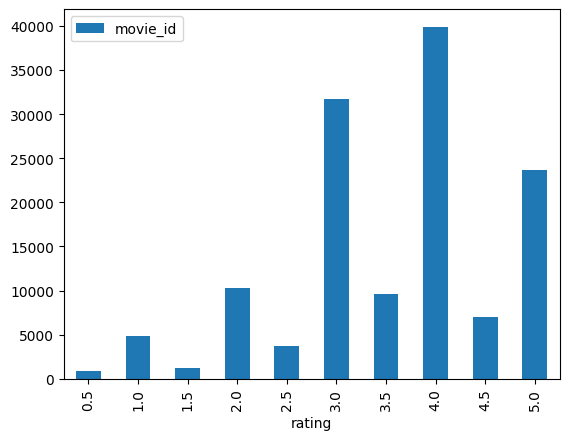

In [32]:
movielens.groupby('rating').agg({'movie_id': len}).plot.bar()

### 5.2.3 평가 방법
- 각 추천 알고리즘의 성능을 측정하는 방법 (자세한 설명은 7장 참고)
- 여기서는 평가값 데이터를 간단하게 추천 알고리즘 학습용 / 평가 테스트용 2가지로 나눔
- 기준
  - 사용자는 적어도 20편 이상의 영화를 평가
  - 가장 최근에 평가한 5개 영화의 평가값을 테스트 용으로 남겨두고 그외의 데이터를 학습용으로 사용

In [33]:
# 학습용과 테스트용으로 데이터를 분할한다
# 각 사용자의 직전 5건의 영화를 평가용으로 사용하고, 그 이외는 학습용으로 한다
# 먼저, 각 사용자가 평가한 영화의 순서를 계산한다
# 직전에 부여한 영화부터 순번을 부여한다(1부터 시작)

movielens['timestamp_rank'] = movielens.groupby(
    'user_id')['timestamp'].rank(ascending=False, method='first')
movielens_train = movielens[movielens['timestamp_rank'] > 5]
movielens_test = movielens[movielens['timestamp_rank']<= 5]

- 학습용 데이터를 사용해 사용자가 가장 최근에 평가한 5개 영화의 평가값을 얼마나 정확하게 예측할 수 있는가로 알고리즘 성능을 평가
- 지표로 RMSE(root mean squared error)를 사용.
  - 예측이 실제 평가값과 완전히 일치하면 RMSE는 0이 됨
  - RMSE가 작을수록 추천 알고리즘 성능이 좋다고 할 수 있음

In [35]:
! pip install scikit-learn

In [43]:
from typing import List
from sklearn.metrics import mean_squared_error

def calc_rmse(self, true_rating: List[float], pred_rating: List[float]) -> float:
    return np.sqrt(mean_squared_error(true_rating, pred_rating))

- `Precision@K`, `Recall@K` 라는 순위 지표로도 추천 알고리즘을 평가함
- Precision@K
  - 사용자에게 K개의 아이템을 추천했을 때 그 중 선호하는 아이템의 비율
- Recall@K
  - 사용자에게 K개의 아이템을 추천했을 때 사용자가 선호하는 아이템 그룹 중 몇 개 맞았는가를 나타내는 비율

- 사용자 별로 Precision@K, Recall@K를 계산해서 Precision@K의 평균과 Recall@K의 평균을 평가지표로 사용
- `Precision@K`, `Recall@K` 순위가 RMSE보다 직관적이므로 실무에서는 순위 지표도 함께 사용하는 것을 권장
- 별 4개와 같은 평가값 데이터가 없는 경우는 클릭이나 구매 등의 암묵적인 평가값으로 순위 지표만 사용 (자세한 내용은 7장)

In [45]:
from typing import Dict

def calc_recall_at_k(
    self, true_user2items: Dict[int, List[int]], pred_user2items: Dict[int, List[int]], k: int
) -> float:
    scores = []
    # 테스트 데이터에 존재하는 각 사용자의 recall@k를 계산
    for user_id in true_user2items.keys():
        r_at_k = self._recall_at_k(true_user2items[user_id], pred_user2items[user_id], k)
        scores.append(r_at_k)
    return np.mean(scores)

def recall_at_k(self, true_items: List[int], pred_items: List[int], k: int) -> float:
    if len(true_items) == 0 or k == 0:
        return 0.0

    r_at_k = (len(set(true_items) & set(pred_items[:k]))) / len(true_items)
    return r_at_k

def calc_precision_at_k(
    self, true_user2items: Dict[int, List[int]], pred_user2items: Dict[int, List[int]], k: int
) -> float:
    scores = []
    # 테스트 데이터에 존재하는 각 사용자의 precision@k를 계산한다
    for user_id in true_user2items.keys():
        p_at_k = self._precision_at_k(true_user2items[user_id], pred_user2items[user_id], k)
        scores.append(p_at_k)
    return np.mean(scores)

def precision_at_k(self, true_items: List[int], pred_items: List[int], k: int) -> float:
    if k == 0:
        return 0.0

    p_at_k = (len(set(true_items) & set(pred_items[:k]))) / k
    return p_at_k

### 5.2.4 통일된 포멧을 활용한 계산
- 통일된 형식으로 기술하면 시스템에 삽입할 떄 알고리즘을 교체하기 쉽고 예측 정확도를 평가하기 쉬움
  - 초보자나 추천 알고리즘을 빠르게 시험하고 싶다면 깃허브에 통일 모듈을 사요하지 않은 알고리즘이 있으니 참고
    ```python
        from util.data_loader import DataLoader
        from util.metric_calculator import MetricCalculator
        
        # 1. MovieLens 데이터 로딩
        data_loader = DataLoader(num_users=1000, num_test_items=5, data_path='./data/ml-10M100K/')
        movielens = data_loader.load()
        
        # 2. 각종 알고리즘 구현
        recommender = XXXRecommender()
        recommend_result = recommender.recommend(movielens)
        
        # 3. 평가 지표 계산
        metric_calculator = MetricCalculator()
        metrics = metric_calculator.calc(
            movielens.test.rating.tolist(), recoomend_result.rating.tolist(),
            movielens.test_user2items, recoomend_result.user2items, k=10)
        print(metrics)
    ```

#### 1. MovieLens 데이터 로딩
- 이제까지 소개한 각 파일의 읽기와 학습용 데이터, 테스트용 데이터 분할 처리 등을 재사용할 수 있게 하기 위해 DataLoader 클래스 안에 정의
  - (util.data_loader 클래스에서 확인 가능)
- DataLoader는 Dataset 클래스를 반환
  - train에는 학습용, test에는 테스트용 평가값 데이터셋이 pandas 데이터프레임 형식으로 저장됨
  - test_user2items에는 각 사용자가 4 이상의 평가값을 준 아이템이 저장되어 있어 `Precision@K`나 `Recall@K` 순위 지표 계산에 사용 가능
  - item_content는 영화의 태그나 장르가 저장된 영화 마스터 데이터임 (콘텐츠 기반 추천에서 사용)

In [6]:
import dataclasses
import pandas as pd
from typing import Dict, List

@dataclasses.dataclass(frozen=True)
# 추천 시스템 학습과 평가에 사용하는 데이터셋
class Dataset:
    # 학습용 평가값 데이터셋
    train: pd.DataFrame
    # 테스트용 평가값 데이터셋
    test: pd.DataFrame
    # 순위 지표 테스트 데이터셋
    # 키는 사용자 ID, 값은 사용자가 높게 평가한 아이템 ID 리스트
    test_user2items: Dict[int, List[int]]
    # 아이템 콘텐츠 정보
    item_content: pd.DataFrame

#### 2. 각종 알고리즘 구현
- dataset을 받아 테스트 데이터의 추천 겨로가를 반환하는 알고리즘을 구현
- 각 알고리즘은 다음 BaseRecommender 클래스를 상속하는 형태로 구현 (src.base_recommender 에서 확인)
  - 추천 결과는 RecommendResult 클래스에서 데이터셋의 예측 평가와 각 사용자에 대한 추천 아이템 리스트를 가짐

In [7]:
import dataclasses
# util.models 에서 확인
@dataclasses.dataclass(frozen=True)
# 추천 시스템의 예측 결과
class RecommendResult:
    # 테스트 데이터셋의 예측 평가값. RMSE 평가
    rating: pd.DataFrame
    # 키는 사용자 Id, 값은 추천 아이템 ID 리스트. 순위 지표 평가
    user2items: Dict[int, List[int]]

- BaseRecommender 클레스에는 run_sample 함수가 있으며 소량의 학습 데이터로 알고리즘을 실행해 그 결과를 확인할 수 있음

#### 3. 평가 지표 계산
- 추천 결과를 기반으로 MetricCalculator를 사용해 RMSE 순위 지표의 `Precision@K`, `Recall@K`를 계산

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error
from util.models import Metrics
from typing import Dict, List


class MetricCalculator:
    def calc(
        self,
        true_rating: List[float],
        pred_rating: List[float],
        true_user2items: Dict[int, List[int]],
        pred_user2items: Dict[int, List[int]],
        k: int,
    ) -> Metrics:
        rmse = self._calc_rmse(true_rating, pred_rating)
        precision_at_k = self._calc_precision_at_k(true_user2items, pred_user2items, k)
        recall_at_k = self._calc_recall_at_k(true_user2items, pred_user2items, k)
        return Metrics(rmse, precision_at_k, recall_at_k)

    def _precision_at_k(self, true_items: List[int], pred_items: List[int], k: int) -> float:
        if k == 0:
            return 0.0

        p_at_k = (len(set(true_items) & set(pred_items[:k]))) / k
        return p_at_k

    def _recall_at_k(self, true_items: List[int], pred_items: List[int], k: int) -> float:
        if len(true_items) == 0 or k == 0:
            return 0.0

        r_at_k = (len(set(true_items) & set(pred_items[:k]))) / len(true_items)
        return r_at_k

    def _calc_rmse(self, true_rating: List[float], pred_rating: List[float]) -> float:
        return np.sqrt(mean_squared_error(true_rating, pred_rating))

    def _calc_recall_at_k(
        self, true_user2items: Dict[int, List[int]], pred_user2items: Dict[int, List[int]], k: int
    ) -> float:
        scores = []
        # テストデータに存在する各ユーザーのrecall@kを計算
        for user_id in true_user2items.keys():
            r_at_k = self._recall_at_k(true_user2items[user_id], pred_user2items[user_id], k)
            scores.append(r_at_k)
        return np.mean(scores)

    def _calc_precision_at_k(
        self, true_user2items: Dict[int, List[int]], pred_user2items: Dict[int, List[int]], k: int
    ) -> float:
        scores = []
        # 테스트 데이터에 존재하는 각 사용자의 precision@k를 계산한다
        for user_id in true_user2items.keys():
            p_at_k = self._precision_at_k(true_user2items[user_id], pred_user2items[user_id], k)
            scores.append(p_at_k)
        return np.mean(scores)

### 5.3 무작위 추천
- 먼저 베이스라인 성능이 얼마나 나오는지 확인
- MovieLens의 평가값은 0.5~5.0이므로 해당 점수 범위로 난수를 발생시키고 그것을 예측 평가값으로 사용
- 학습용 데이터에 나타난 사용자와 아이템으로 사용자x아이템의 행렬을 만들고 각 셀에 난수를 저장
- 순위 지표 계산용으로 prod_user2items라는 딕셔너리를 작성하고 key에 user_id, value에 아직 사용자가 평가하지 않은 영화부터 무작위로 10개의 영화를 저장

In [1]:
from util.models import RecommendResult, Dataset
from src.base_recommender import BaseRecommender
from collections import defaultdict
import numpy as np

np.random.seed(0)


class RandomRecommender(BaseRecommender):
    def recommend(self, dataset: Dataset, **kwargs) -> RecommendResult:
        # 사용자 ID와 아이템 ID에 대해 0부터 시작하는 인덱스를 할당한다
        unique_user_ids = sorted(dataset.train.user_id.unique())
        unique_movie_ids = sorted(dataset.train.movie_id.unique())
        user_id2index = dict(zip(unique_user_ids, range(len(unique_user_ids))))
        movie_id2index = dict(zip(unique_movie_ids, range(len(unique_movie_ids))))

        # 사용자 x 아이템의 행렬에서 각 셀의 예측 평갓값은 0.5~5.0의 균등 난수로 한다
        pred_matrix = np.random.uniform(0.5, 5.0, (len(unique_user_ids), len(unique_movie_ids)))

        # rmse 평가용으로 테스트 데이터에 나오는 사용자와 아이템의 예측 평갓값을 저장한다
        movie_rating_predict = dataset.test.copy()
        pred_results = []
        for i, row in dataset.test.iterrows():
            user_id = row["user_id"]
            # 테스트 데이터의 아이템 ID가 학습용으로 등장하지 않는 경우도 난수를 저장한다
            if row["movie_id"] not in movie_id2index:
                pred_results.append(np.random.uniform(0.5, 5.0))
                continue
            # 테스트 데이터에 나타나는 사용자 ID와 아이템 ID의 인덱스를 얻어, 평갓값 행렬값을 얻는다
            user_index = user_id2index[row["user_id"]]
            movie_index = movie_id2index[row["movie_id"]]
            pred_score = pred_matrix[user_index, movie_index]
            pred_results.append(pred_score)
        movie_rating_predict["rating_pred"] = pred_results

        # 순위 평가용 데이터 작성
        # 각 사용자에 대한 추천 영화는, 해당 사용자가 아직 평가하지 않은 영화 중에서 무작위로 10개 작품으로 한다
        # 키는 사용자 ID, 값은 추천 아이템의 ID 리스트
        pred_user2items = defaultdict(list)
        # 사용자가 이미 평가한 영화를 저장한다
        user_evaluated_movies = dataset.train.groupby("user_id").agg({"movie_id": list})["movie_id"].to_dict()
        for user_id in unique_user_ids:
            user_index = user_id2index[user_id]
            movie_indexes = np.argsort(-pred_matrix[user_index, :])
            for movie_index in movie_indexes:
                movie_id = unique_movie_ids[movie_index]
                if movie_id not in user_evaluated_movies[user_id]:
                    pred_user2items[user_id].append(movie_id)
                if len(pred_user2items[user_id]) == 10:
                    break
        return RecommendResult(movie_rating_predict.rating_pred, pred_user2items)


if __name__ == "__main__":
    RandomRecommender().run_sample()

rmse=1.890, Precision@K=0.001, Recall@K=0.001


- Precision@K, Recall@K가 0에 가까우며 적절하게 추천되지 않았음을 알 수 있음
- 무작위로 영화를 추천해도 그것을 선호할 가능성이 없음을 나타냄
- 다음 절 부터는 사용자가 선호하는 영화를 추천하는 방법에 대해 알아봄